In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

Mean Squared Error (RBF Kernel): 0.19026912346817074


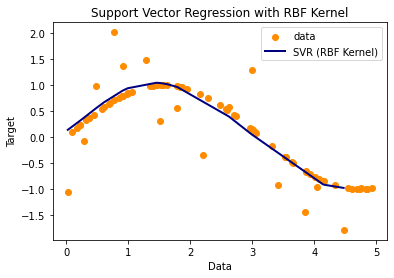

In [14]:
np.random.seed(42)
X = np.sort(5 * np.random.rand(80, 1), axis=0)
y = np.sin(X).ravel()

# Add noise to targets
y[::5] += 3 * (0.5 - np.random.rand(16))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svr_rbf = SVR(kernel='rbf', C=1.0, gamma='scale')
svr_rbf.fit(X_train, y_train)

# Sort the test set for smooth plotting
X_test_sorted = np.sort(X_test, axis=0)

# Make predictions on the sorted test set
y_pred_rbf_sorted = svr_rbf.predict(X_test_sorted)

# Evaluate the model
mse_rbf = mean_squared_error(y_test, svr_rbf.predict(X_test))
print(f"Mean Squared Error (RBF Kernel): {mse_rbf}")

# Plot the results
plt.scatter(X, y, color='darkorange', label='data')
plt.plot(X_test_sorted, y_pred_rbf_sorted, color='navy', lw=2, label='SVR (RBF Kernel)')
plt.title('Support Vector Regression with RBF Kernel')
plt.xlabel('Data')
plt.ylabel('Target')
plt.legend()
plt.show()

Mean Squared Error: 0.030249363890155884


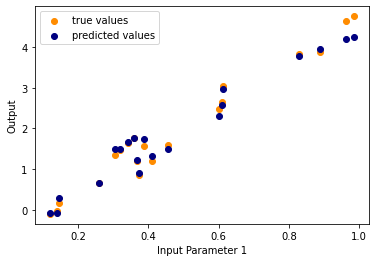

In [19]:
# Generate some sample data
np.random.seed(42)
X = np.random.rand(100, 2)  # 3 input parameters
y = 5 * X[:, 0] + 2 * X[:, 1] - 3 * X[:, 1] + np.random.normal(0, 0.1, 100)  # Linear relationship with noise

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the MLP Regressor
mlp_regressor = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', max_iter=1000, random_state=42)
mlp_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = mlp_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Plot the results (only for 2D visualization)
if X_train.shape[1] == 2:
    plt.scatter(X_test[:, 0], y_test, color='darkorange', label='true values')
    plt.scatter(X_test[:, 0], y_pred, color='navy', label='predicted values')
    plt.xlabel('Input Parameter 1')
    plt.ylabel('Output')
    plt.legend()
    plt.show()